In [1]:
!pip install transformers datasets torch torchvision
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from transformers import DetrImageProcessor, DetrForObjectDetection


In [4]:
dataset = load_dataset("detection-datasets/fashionpedia", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [5]:
# Select the first 500 samples
dataset = dataset.select(range(500))

In [6]:
dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 500
})

In [7]:
dataset.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'width': Value(dtype='int64', id=None),
 'height': Value(dtype='int64', id=None),
 'objects': Sequence(feature={'bbox_id': Value(dtype='int64', id=None), 'category': ClassLabel(names=['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel'], id=None), 'bbox': Sequence(feature=Value(dtype='float64', id=None), length=4, id=None), 'area': Value(dtype='int64', id=None)}, length=-1, id=None)}

In [8]:
dataset = dataset.train_test_split(test_size=0.2)

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 400
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 100
    })
})

In [10]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [11]:
import numpy as np
from PIL import Image, ImageDraw


id2label = {
    0: "shirt, blouse",
    1: "top, t-shirt, sweatshirt",
    2: "sweater",
    3: "cardigan",
    4: "jacket",
    5: "vest",
    6: "pants",
    7: "shorts",
    8: "skirt",
    9: "coat",
    10: "dress",
    11: "jumpsuit",
    12: "cape",
    13: "glasses",
    14: "hat",
    15: "headband, head covering, hair accessory",
    16: "tie",
    17: "glove",
    18: "watch",
    19: "belt",
    20: "leg warmer",
    21: "tights, stockings",
    22: "sock",
    23: "shoe",
    24: "bag, wallet",
    25: "scarf",
    26: "umbrella",
    27: "hood",
    28: "collar",
    29: "lapel",
    30: "epaulette",
    31: "sleeve",
    32: "pocket",
    33: "neckline",
    34: "buckle",
    35: "zipper",
    36: "applique",
    37: "bead",
    38: "bow",
    39: "flower",
    40: "fringe",
    41: "ribbon",
    42: "rivet",
    43: "ruffle",
    44: "sequin",
    45: "tassel",
}


label2id = {v: k for k, v in id2label.items()}

{'bbox_id': [168230, 168231, 168232, 168233, 168234, 168235], 'category': [10, 31, 31, 33, 23, 23], 'bbox': [[193.0, 224.0, 447.0, 810.0], [367.0, 242.0, 447.0, 427.0], [207.0, 224.0, 242.0, 470.0], [244.0, 224.0, 388.0, 264.0], [182.0, 809.0, 223.0, 893.0], [325.0, 785.0, 365.0, 865.0]], 'area': [80105, 6362, 6398, 225, 1808, 1732]}


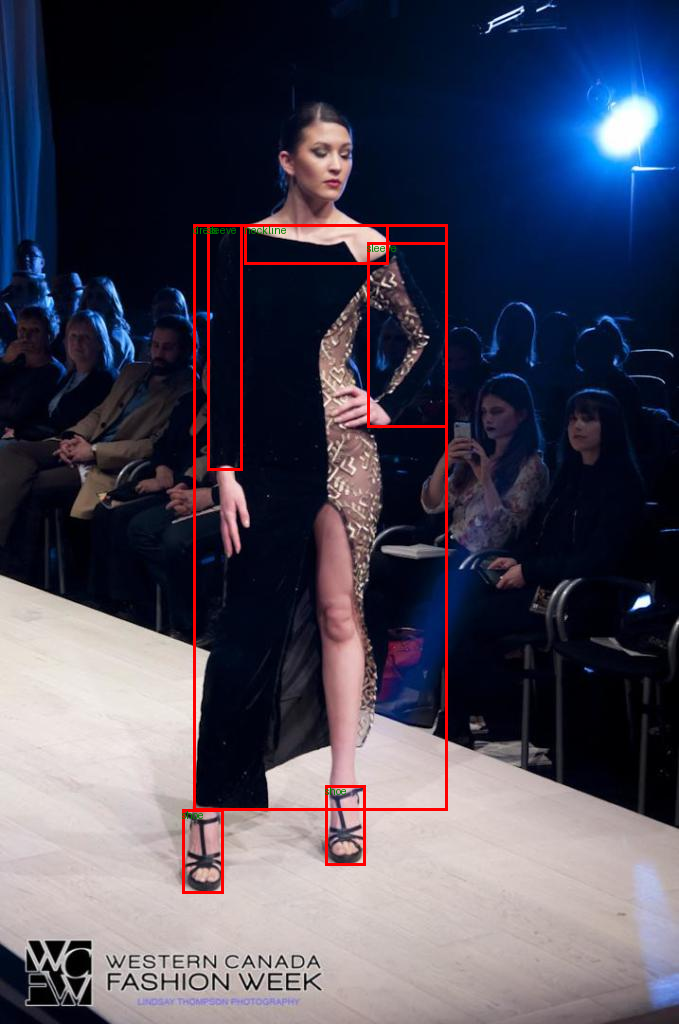

In [12]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    print(annotations)

    for i in range(len(annotations["bbox_id"])):
        box = annotations["bbox"][i]
        x1, y1, x2, y2 = tuple(box)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), id2label[annotations["category"][i]], fill="green")

    return image


draw_image_from_idx(dataset=train_dataset, idx=10)  # You can test changing this id

{'bbox_id': [159135], 'category': [10], 'bbox': [[191.0, 310.0, 580.0, 1023.0]], 'area': [122410]}
{'bbox_id': [159343, 159344, 159345, 159346], 'category': [14, 8, 31, 1], 'bbox': [[328.0, 54.0, 521.0, 189.0], [254.0, 565.0, 704.0, 681.0], [283.0, 283.0, 441.0, 418.0], [247.0, 283.0, 497.0, 589.0]], 'area': [9049, 42493, 12785, 52423]}
{'bbox_id': [159948, 159949, 159950], 'category': [33, 1, 8], 'bbox': [[164.0, 314.0, 540.0, 387.0], [107.0, 314.0, 620.0, 799.0], [101.0, 764.0, 450.0, 999.0]], 'area': [1429, 150641, 64349]}
{'bbox_id': [191174, 191175, 191176, 191177, 191178, 191179], 'category': [23, 23, 6, 32, 1, 33], 'bbox': [[317.0, 886.0, 366.0, 979.0], [358.0, 885.0, 401.0, 968.0], [306.0, 505.0, 491.0, 899.0], [317.0, 505.0, 341.0, 523.0], [310.0, 265.0, 497.0, 958.0], [371.0, 273.0, 422.0, 317.0]], 'area': [1581, 1325, 45406, 304, 51557, 230]}
{'bbox_id': [160201, 160202, 160203, 160204, 160205, 160206], 'category': [8, 1, 31, 33, 15, 31], 'bbox': [[184.0, 593.0, 504.0, 962.0

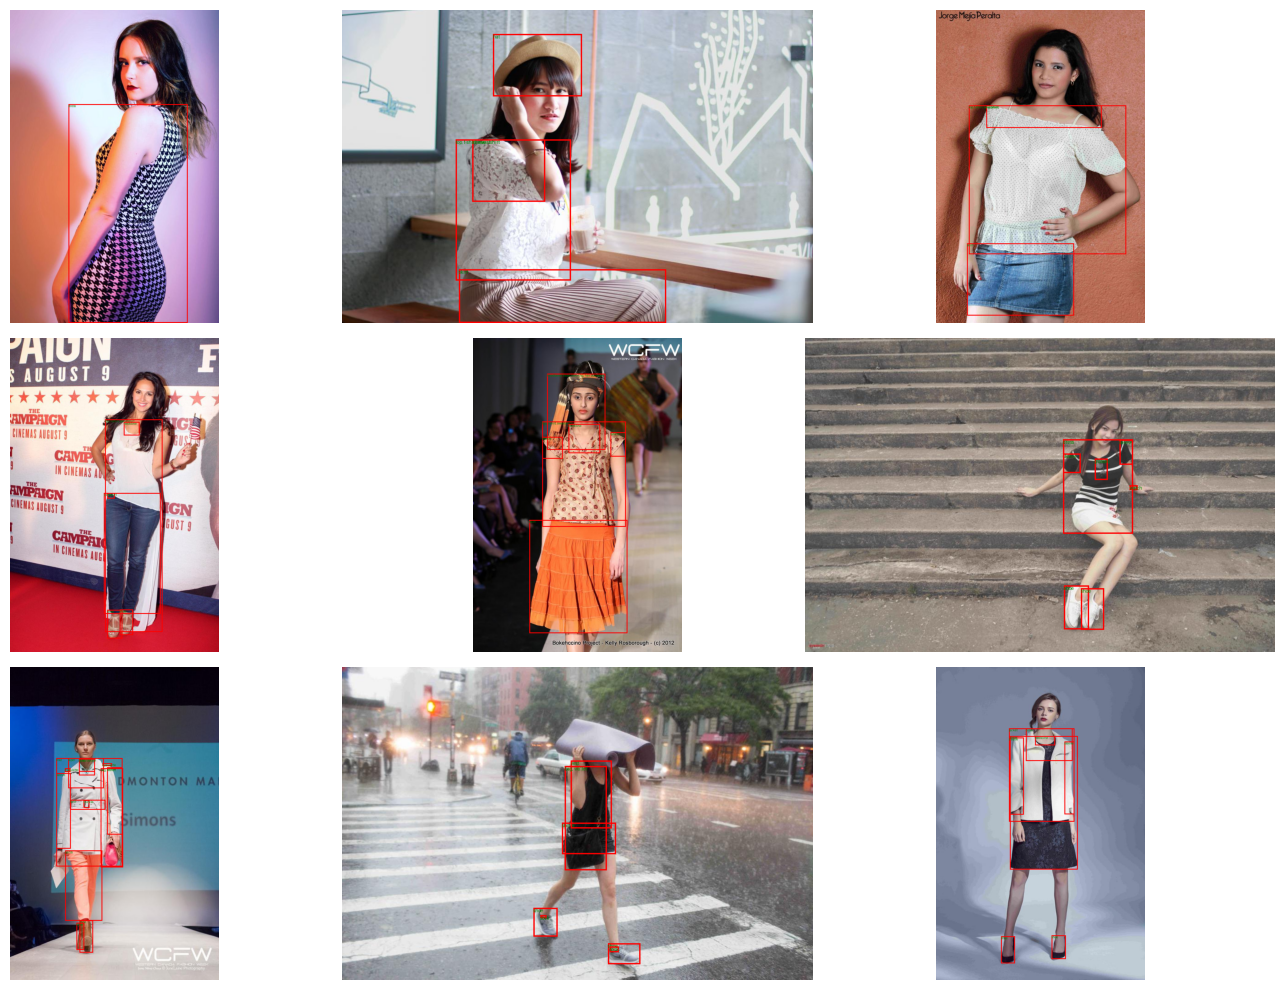

In [13]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_cols = 3
    num_rows = int(np.ceil(len(indices) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_image_from_idx(dataset, idx)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


plot_images(train_dataset, range(9))

In [14]:
from datasets import Dataset


def filter_invalid_bboxes(example):
    valid_bboxes = []
    valid_bbox_ids = []
    valid_categories = []
    valid_areas = []

    for i, bbox in enumerate(example["objects"]["bbox"]):
        x_min, y_min, x_max, y_max = bbox[:4]
        if x_min < x_max and y_min < y_max:
            valid_bboxes.append(bbox)
            valid_bbox_ids.append(example["objects"]["bbox_id"][i])
            valid_categories.append(example["objects"]["category"][i])
            valid_areas.append(example["objects"]["area"][i])
        else:
            print(
                f"Image with invalid bbox: {example['image_id']} Invalid bbox detected and discarded: {bbox} - bbox_id: {example['objects']['bbox_id'][i]} - category: {example['objects']['category'][i]}"
            )

    example["objects"]["bbox"] = valid_bboxes
    example["objects"]["bbox_id"] = valid_bbox_ids
    example["objects"]["category"] = valid_categories
    example["objects"]["area"] = valid_areas

    return example


train_dataset = train_dataset.map(filter_invalid_bboxes)
test_dataset = test_dataset.map(filter_invalid_bboxes)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 400
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 100
})


In [16]:
id_list = []
category_examples = {}
for example in train_dataset:
    id_list += example["objects"]["bbox_id"]
    for category in example["objects"]["category"]:
        if id2label[category] not in category_examples:
            category_examples[id2label[category]] = 1
        else:
            category_examples[id2label[category]] += 1

id_list.sort()

<ipython-input-17-ec0e47ed081b>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=90, ha="right")


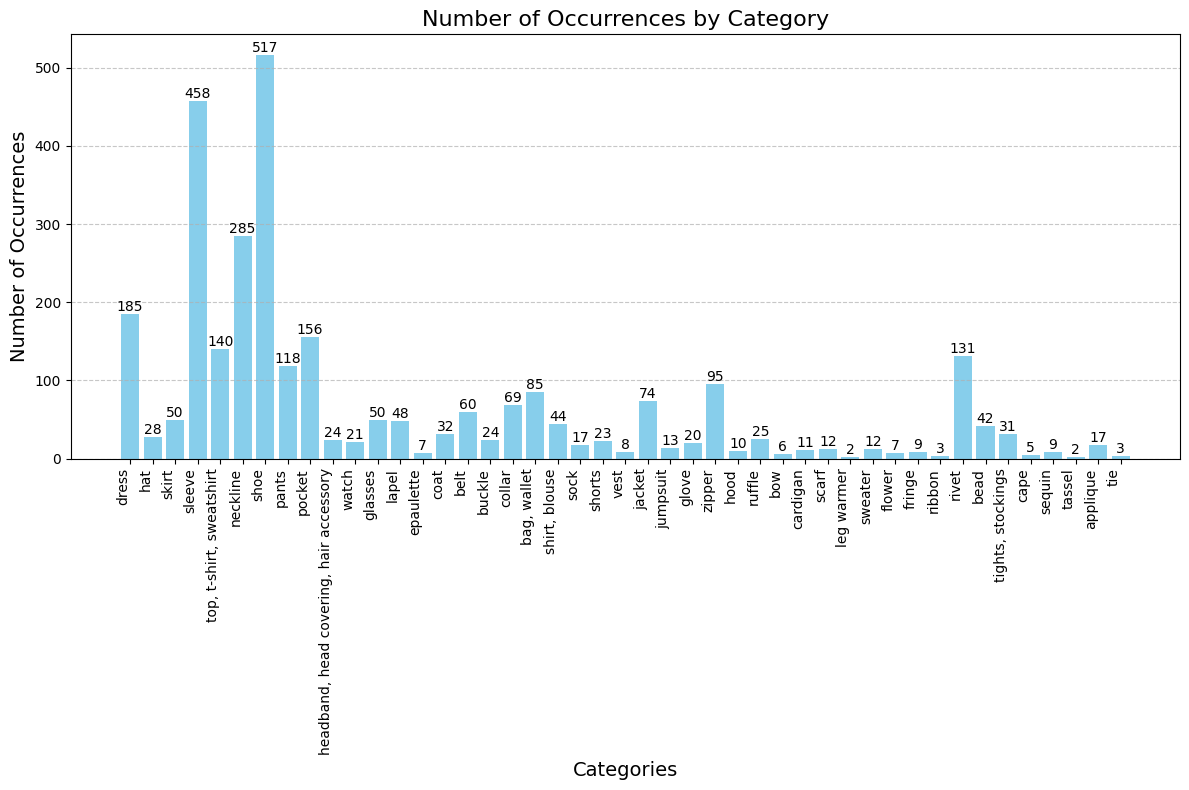

In [17]:
import matplotlib.pyplot as plt

categories = list(category_examples.keys())
values = list(category_examples.values())

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(categories, values, color="skyblue")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.set_xticklabels(categories, rotation=90, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
import albumentations as A

train_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]),
)

val_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]),
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [19]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [20]:
def formatted_anns(image_id, category, area, bbox):
    if not (len(category) == len(area) == len(bbox)):
        raise ValueError("category, area, and bbox must all have the same number of elements")
    annotations = []
    for i in range(len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations


def convert_voc_to_coco(bbox):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    return [xmin, ymin, width, height]


def transform_aug_ann(examples, transform):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        # Normalize data lengths
        min_len = min(len(out['bboxes']), len(objects['area']), len(out['category']))
        area.append(objects["area"][:min_len])
        bboxes.append([convert_voc_to_coco(bbox) for bbox in out['bboxes'][:min_len]])
        categories.append(out['category'][:min_len])
        images.append(out["image"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")



def transform_train(examples):
    return transform_aug_ann(examples, transform=train_transform)


def transform_val(examples):
    return transform_aug_ann(examples, transform=val_transform)


train_dataset_transformed = train_dataset.with_transform(transform_train)
test_dataset_transformed = test_dataset.with_transform(transform_val)

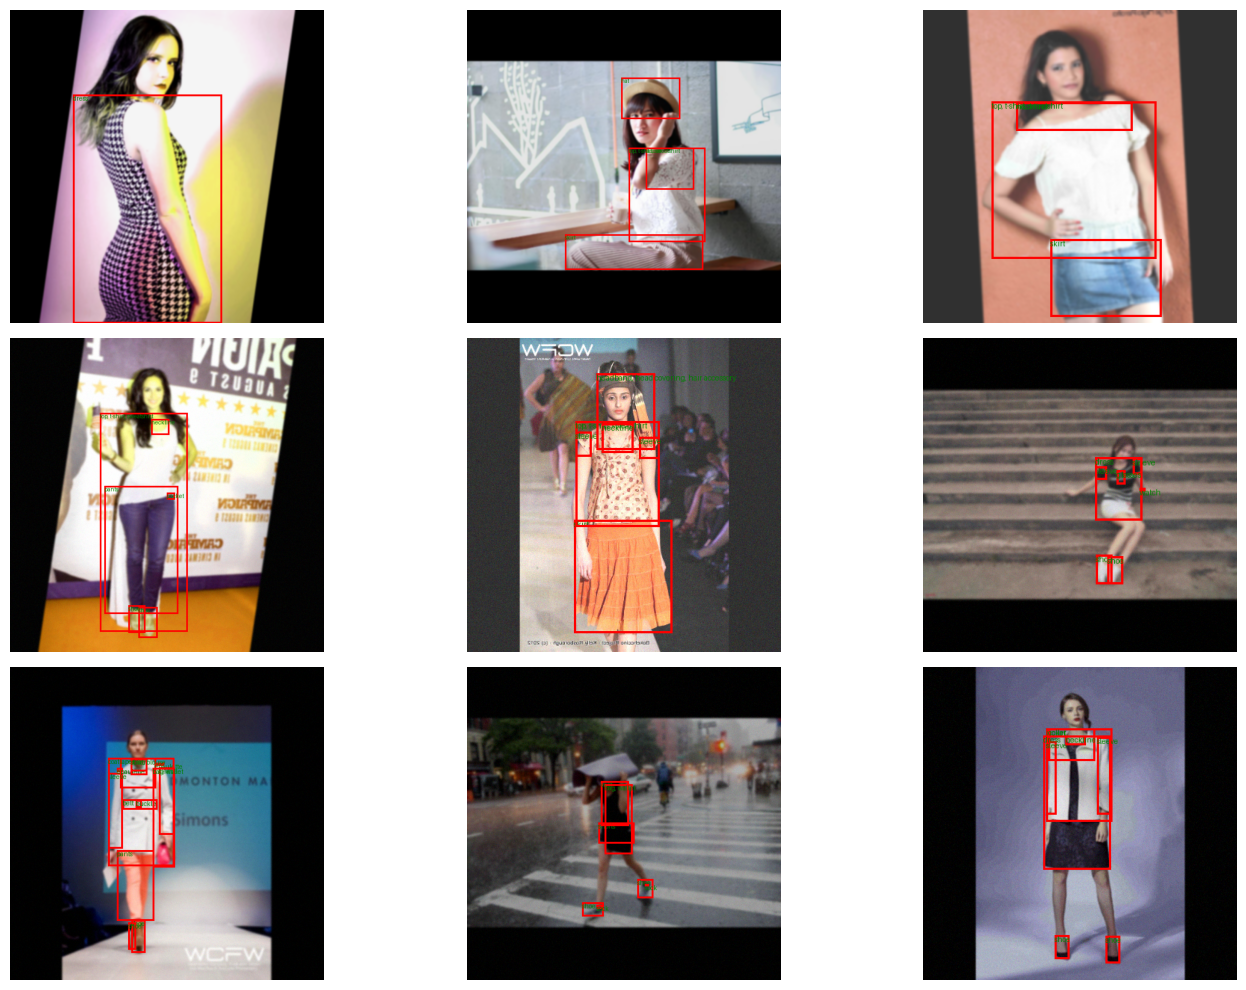

In [21]:
# Updated draw function to accept an optional transform
def draw_augmented_image_from_idx(dataset, idx, transform=None):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]

    # Convert image to RGB and NumPy array
    image = np.array(image.convert("RGB"))[:, :, ::-1]

    if transform:
        augmented = transform(image=image, bboxes=annotations["bbox"], category=annotations["category"])
        image = augmented["image"]
        annotations["bbox"] = augmented["bboxes"]
        annotations["category"] = augmented["category"]

    image = Image.fromarray(image[:, :, ::-1])  # Convert back to PIL Image
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["bbox_id"])):
        box = annotations["bbox"][i]
        x1, y1, x2, y2 = tuple(box)

        # Normalize coordinates if necessary
        if max(box) <= 1.0:
            x1, y1 = int(x1 * width), int(y1 * height)
            x2, y2 = int(x2 * width), int(y2 * height)
        else:
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)

        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), id2label[annotations["category"][i]], fill="green")

    return image


# Updated plot function to include augmentation
def plot_augmented_images(dataset, indices, transform=None):
    """
    Plot images and their annotations with optional augmentation.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw augmented image
        image = draw_augmented_image_from_idx(dataset, idx, transform=transform)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot augmented images
plot_augmented_images(train_dataset, range(9), transform=train_transform)

In [22]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

In [23]:
# prompt: huggingface login with ui

from huggingface_hub import notebook_login

notebook_login()

In [30]:
from transformers import TrainingArguments
from transformers import Trainer

import torch

# Define the training arguments

training_args = TrainingArguments(
    output_dir="detr-resnet_finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=3000,
    fp16=True,
    save_steps=10,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    eval_steps=50,
    eval_strategy="steps",
    report_to="none",
    push_to_hub=True,
    batch_eval_metrics=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.8 MB/s eta 0:00:00


In [31]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax


def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width  # xmin
    boxes[:, 1] *= height  # ymin
    boxes[:, 2] *= width  # xmax
    boxes[:, 3] *= height  # ymax
    return boxes


batch_metrics = []


def compute_metrics(eval_pred, compute_result):
    global batch_metrics

    (loss_dict, scores, pred_boxes, last_hidden_state, encoder_last_hidden_state), labels = eval_pred

    image_sizes = []
    target = []
    for label in labels:

        image_sizes.append(label["orig_size"])
        width, height = label["orig_size"]
        denormalized_boxes = denormalize_boxes(label["boxes"], width, height)
        target.append(
            {
                "boxes": denormalized_boxes,
                "labels": label["class_labels"],
            }
        )
    predictions = []
    for score, box, target_sizes in zip(scores, pred_boxes, image_sizes):
        # Extract the bounding boxes, labels, and scores from the model's output
        pred_scores = score[:, :-1]  # Exclude the no-object class
        pred_scores = softmax(pred_scores, dim=-1)
        width, height = target_sizes
        pred_boxes = denormalize_boxes(box, width, height)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # Get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append(
            {
                "boxes": pred_boxes,
                "scores": pred_scores_for_labels,
                "labels": pred_labels,
            }
        )

    metric = MeanAveragePrecision(box_format="xywh", class_metrics=True)

    if not compute_result:
        # Accumulate batch-level metrics
        batch_metrics.append({"preds": predictions, "target": target})
        return {}
    else:
        # Compute final aggregated metrics
        # Aggregate batch-level metrics (this should be done based on your metric library's needs)
        all_preds = []
        all_targets = []
        for batch in batch_metrics:
            all_preds.extend(batch["preds"])
            all_targets.extend(batch["target"])

        # Update metric with all accumulated predictions and targets
        metric.update(preds=all_preds, target=all_targets)
        metrics = metric.compute()

        # Convert and format metrics as needed
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")

        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        # Round metrics for cleaner output
        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        # Clear batch metrics for next evaluation
        batch_metrics = []

        return metrics

In [32]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels

    return batch

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

<ipython-input-33-ce91aca5ddce>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
max_steps is given, it will override any value given in num_train_epochs


In [34]:
trainer.evaluate()

{'eval_loss': 7.374630928039551,
 'eval_model_preparation_time': 0.0124,
 'eval_map': 0.0001,
 'eval_map_50': 0.0002,
 'eval_map_75': 0.0,
 'eval_map_small': 0.0,
 'eval_map_medium': 0.0,
 'eval_map_large': 0.0003,
 'eval_mar_1': 0.0005,
 'eval_mar_10': 0.0033,
 'eval_mar_100': 0.0115,
 'eval_mar_small': 0.0,
 'eval_mar_medium': 0.0047,
 'eval_mar_large': 0.0219,
 'eval_map_shirt, blouse': 0.0,
 'eval_mar_100_shirt, blouse': 0.0,
 'eval_map_top, t-shirt, sweatshirt': 0.0,
 'eval_mar_100_top, t-shirt, sweatshirt': 0.0,
 'eval_map_cardigan': 0.0,
 'eval_mar_100_cardigan': 0.0,
 'eval_map_jacket': 0.0,
 'eval_mar_100_jacket': 0.0,
 'eval_map_vest': 0.0,
 'eval_mar_100_vest': 0.0,
 'eval_map_pants': 0.0,
 'eval_mar_100_pants': 0.0,
 'eval_map_shorts': 0.0,
 'eval_mar_100_shorts': 0.0,
 'eval_map_skirt': 0.0,
 'eval_mar_100_skirt': 0.0,
 'eval_map_coat': 0.0002,
 'eval_mar_100_coat': 0.1714,
 'eval_map_dress': 0.0017,
 'eval_mar_100_dress': 0.1959,
 'eval_map_jumpsuit': 0.0,
 'eval_mar_100_

In [35]:
train_results = trainer.train()

In [37]:
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         30.0
  total_flos               = 5341364293GF
  train_loss               =       3.2792
  train_runtime            =   1:58:45.69
  train_samples_per_second =        1.684
  train_steps_per_second   =        0.421


In [38]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                                                =       30.0
  eval_loss                                            =     2.6712
  eval_map                                             =     0.0058
  eval_map_50                                          =     0.0128
  eval_map_75                                          =     0.0046
  eval_map_applique                                    =        0.0
  eval_map_bag, wallet                                 =        0.0
  eval_map_belt                                        =        0.0
  eval_map_bow                                         =        0.0
  eval_map_buckle                                      =        0.0
  eval_map_cape                                        =        0.0
  eval_map_cardigan                                    =        0.0
  eval_map_coat                                        =        0.0
  eval_map_collar                                      =        0.0
  eval_map_dress       

In [39]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/osmanh/detr-resnet_finetuned/commit/bbb55d0a0bdc47c2b9d727dd267b1591c18e5cc2', commit_message='End of training', commit_description='', oid='bbb55d0a0bdc47c2b9d727dd267b1591c18e5cc2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/detr-resnet_finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/detr-resnet_finetuned'), pr_revision=None, pr_num=None)

## Testing

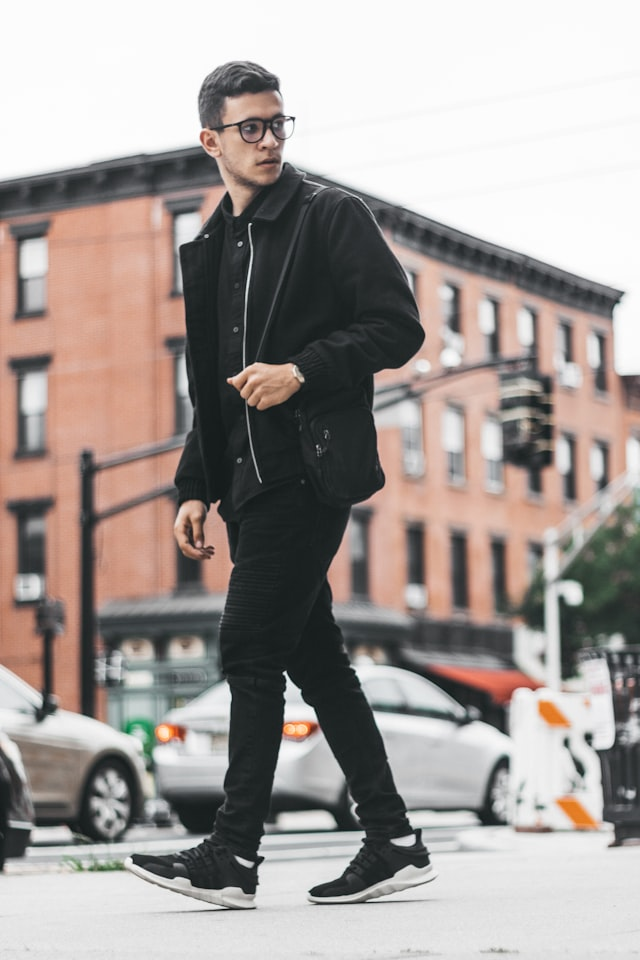

In [40]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1536243298747-ea8874136d64?q=80&w=640"

image = Image.open(requests.get(url, stream=True).raw)

image

In [41]:
obj_detector = pipeline(
    "object-detection", model="osmanh/detr-resnet_finetuned"
)


results = obj_detector(image)
print(results)

config.json:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[]


In [42]:
from PIL import Image, ImageDraw
import numpy as np


def plot_results(image, results, threshold=0.6):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())

        if score > threshold:
            x1, y1, x2, y2 = tuple(box)
            draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
            draw.text((x1 + 5, y1 - 10), label, fill="white")
            draw.text((x1 + 5, y1 + 10), f"{score:.2f}", fill="green" if score > 0.7 else "red")

    return image

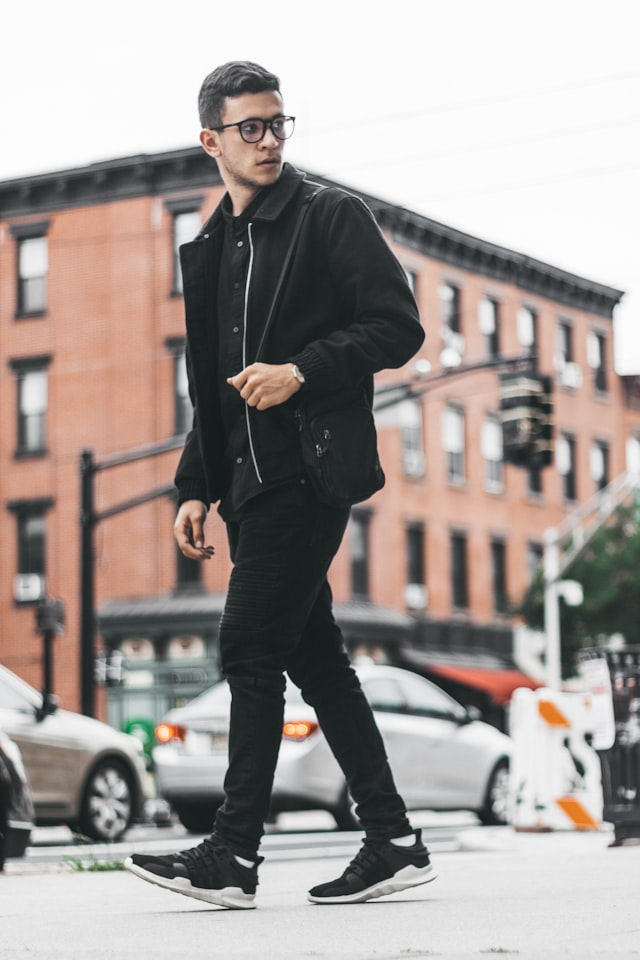

In [43]:
plot_results(image, results)

In [44]:
metrics = trainer.evaluate(test_dataset_transformed)
print(metrics)

{'eval_loss': 2.6711971759796143, 'eval_model_preparation_time': 0.0124, 'eval_map': 0.0058, 'eval_map_50': 0.0128, 'eval_map_75': 0.0046, 'eval_map_small': 0.0042, 'eval_map_medium': 0.0081, 'eval_map_large': 0.0055, 'eval_mar_1': 0.0128, 'eval_mar_10': 0.0308, 'eval_mar_100': 0.0362, 'eval_mar_small': 0.0239, 'eval_mar_medium': 0.0494, 'eval_mar_large': 0.0448, 'eval_map_shirt, blouse': 0.0, 'eval_mar_100_shirt, blouse': 0.0, 'eval_map_top, t-shirt, sweatshirt': 0.0, 'eval_mar_100_top, t-shirt, sweatshirt': 0.0, 'eval_map_cardigan': 0.0, 'eval_mar_100_cardigan': 0.0, 'eval_map_jacket': 0.0, 'eval_mar_100_jacket': 0.0, 'eval_map_vest': 0.0, 'eval_mar_100_vest': 0.0, 'eval_map_pants': 0.0, 'eval_mar_100_pants': 0.0, 'eval_map_shorts': 0.0, 'eval_mar_100_shorts': 0.0, 'eval_map_skirt': 0.0, 'eval_mar_100_skirt': 0.0, 'eval_map_coat': 0.0, 'eval_mar_100_coat': 0.0, 'eval_map_dress': 0.0681, 'eval_mar_100_dress': 0.2918, 'eval_map_jumpsuit': 0.0, 'eval_mar_100_jumpsuit': 0.0, 'eval_map_ca